# Drift Monitoring for XGBoost Regressor

This notebook provides a comprehensive approach to monitor drift in both target and features across different populations for an XGBoost Regressor model. It leverages holistic metrics such as the Population Stability Index (PSI) and visualizations to ensure robust model performance over time.

---
## Table of Contents
1. [Introduction](#introduction)
2. [Setup & Imports](#setup-imports)
3. [Load Data & Model](#load-data-model)
4. [Feature & Target Drift Overview](#feature-target-drift-overview)
5. [Population Stability Index (PSI)](#psi)
6. [Drift Visualization](#drift-visualization)
7. [Summary & Recommendations](#summary-recommendations)
---

## 1. Introduction
Drift monitoring is essential to ensure that your model remains reliable as data distributions change over time or across different populations. This notebook demonstrates how to detect and visualize drift in both features and target variables for an XGBoost Regressor using holistic metrics such as the Population Stability Index (PSI).

## 2. Setup & Imports
Import all necessary libraries for data manipulation, visualization, and drift calculation.

In [17]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from typing import List, Tuple
import xgboost as xgb
import joblib
import os
import sys
from sklearn.metrics import mean_squared_error, mean_absolute_error
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)
from src.core.config_loader import ConfigLoader
from src.core.clients.bigquery import BigQueryClient
from src.core.models.xgboost import XgboostModel

%matplotlib inline

bq_client = BigQueryClient()
config_loader = ConfigLoader()



INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines


## 3. Load Data & Model
Load the reference (baseline) and current (production or new) datasets, as well as the trained XGBoost model.

In [18]:
# Define paths to your data and model
model = XgboostModel().load_model(
    '/Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260127_133929/model_0.pickle'
)

reference_df = model.training_df
current_df = model.validation_df

feature_importance = pd.read_csv(f"{model.run_directory}/feature_importance.csv")


# Display basic info
print(f"Reference data shape: {reference_df.shape}")
print(f"Current data shape: {current_df.shape}")

INFO:src.core.models.xgboost:Model loaded from /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260127_133929/model_0.pickle


Reference data shape: (73203, 525)
Current data shape: (20272, 525)


## 4. Feature & Target Drift Overview
Let's get a quick overview of the distributions for both features and the target variable in the reference and current datasets.

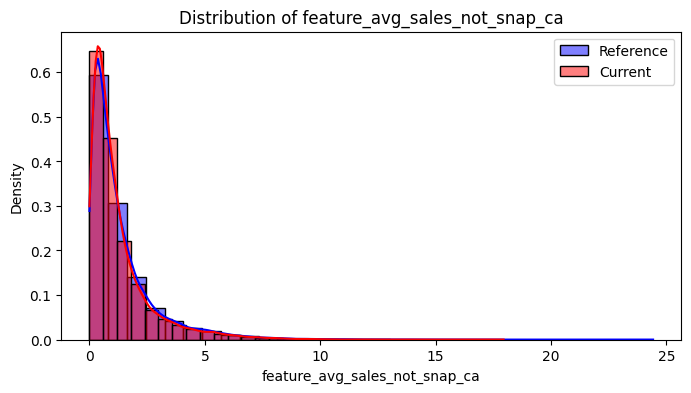

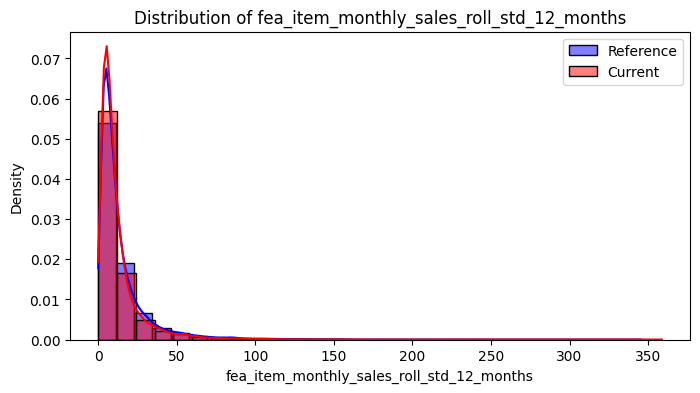

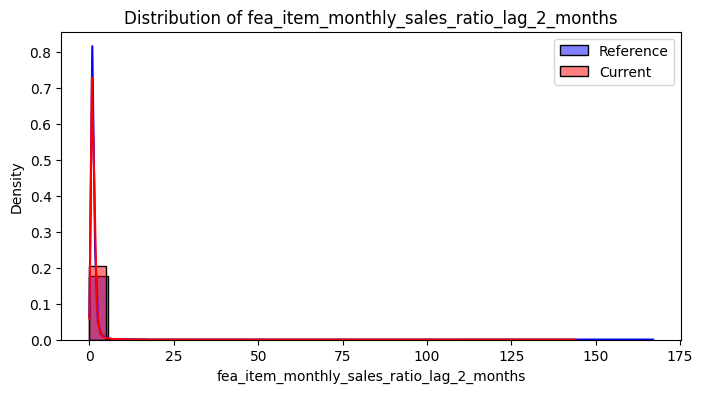

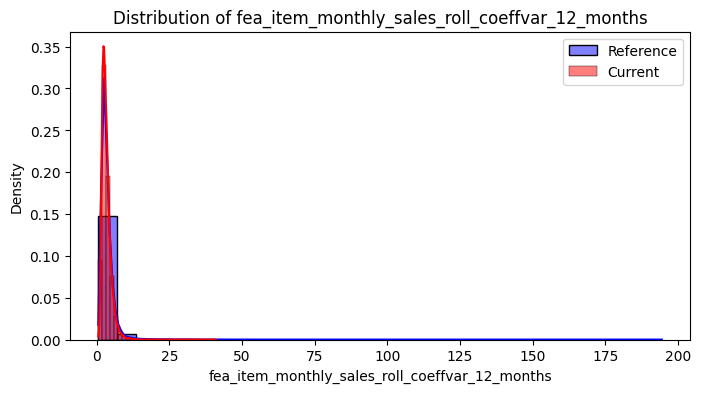

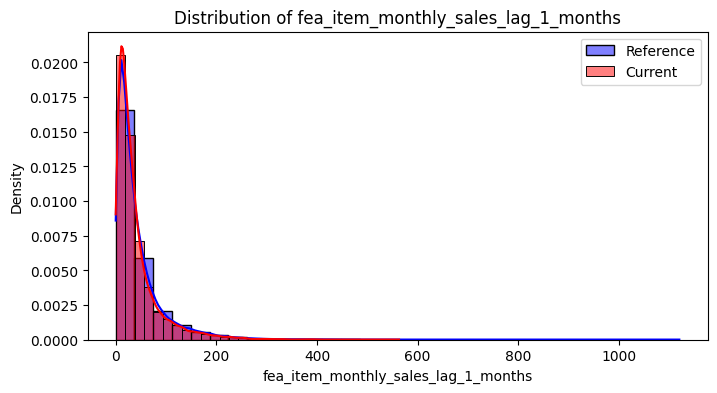

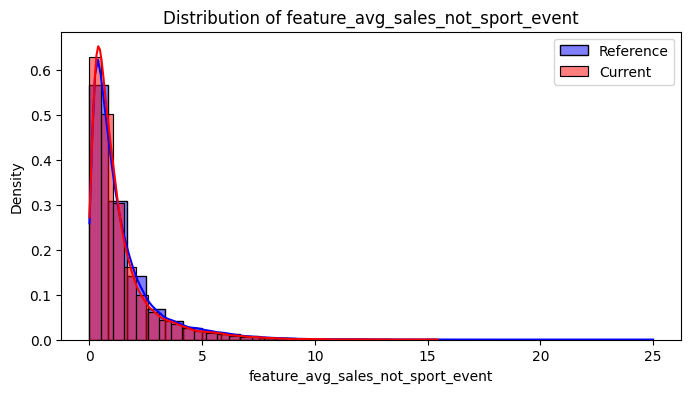

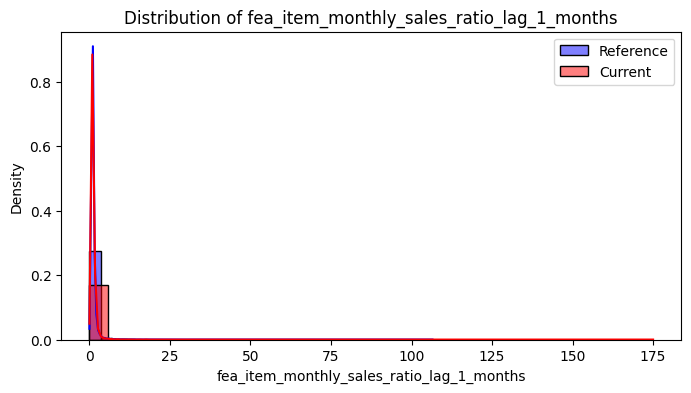

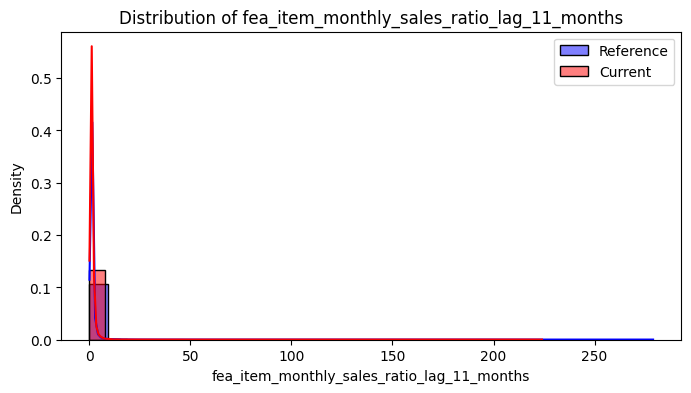

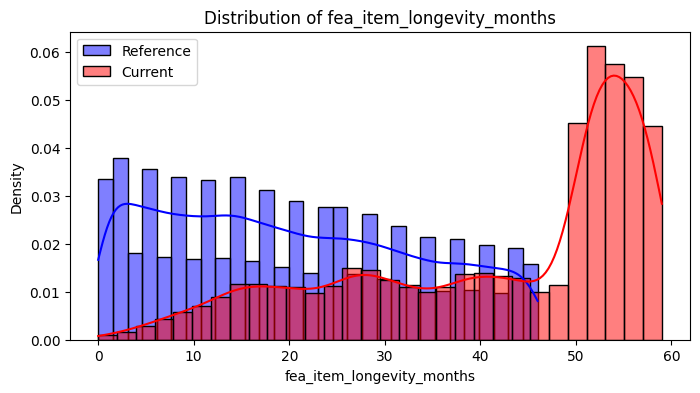

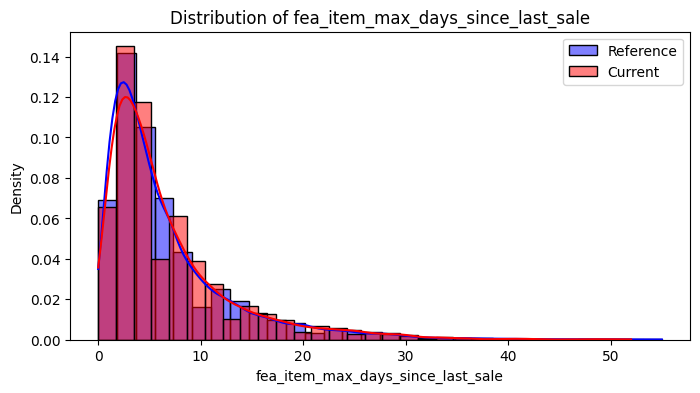

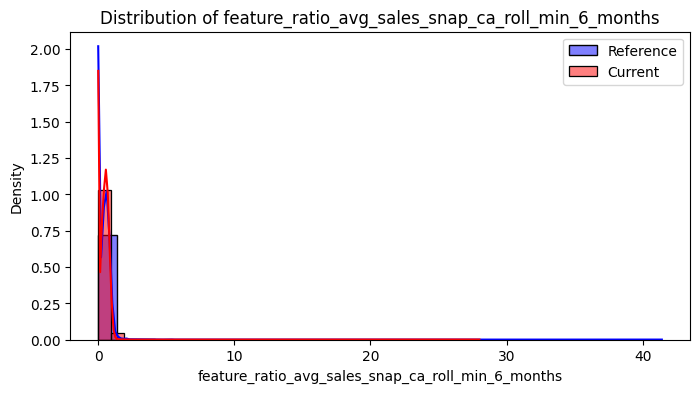

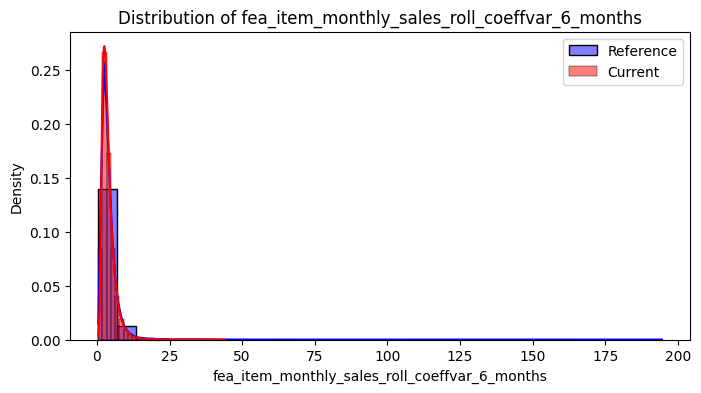

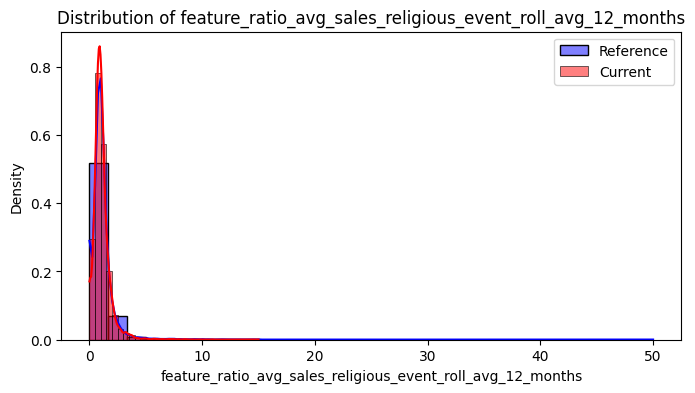

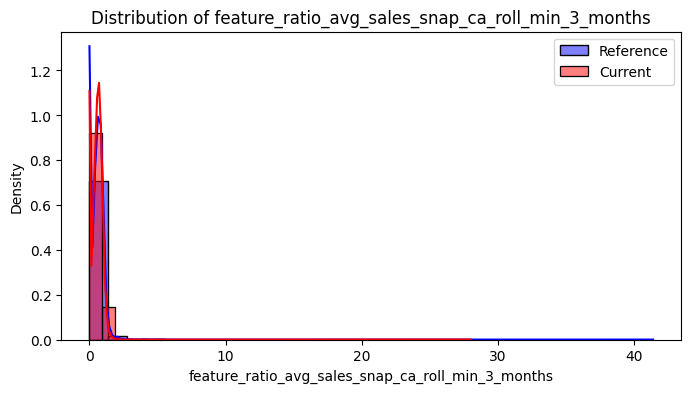

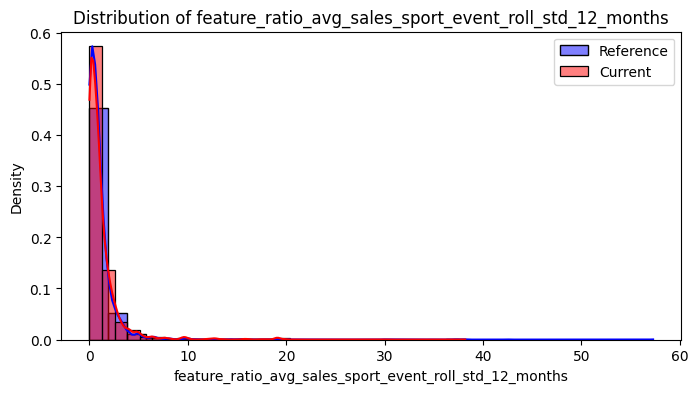

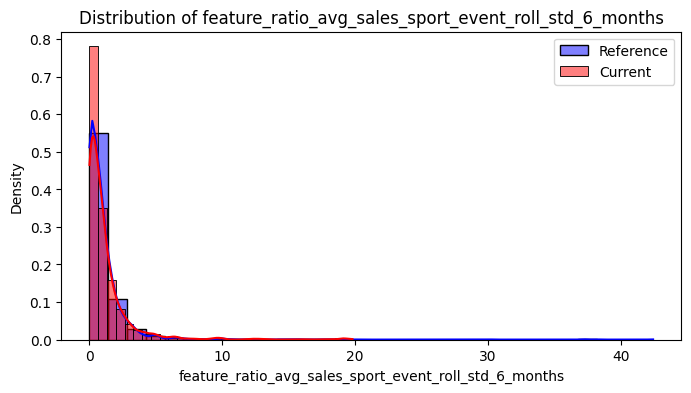

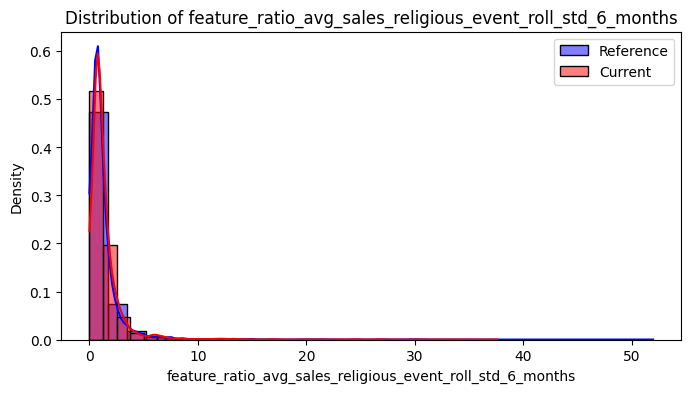

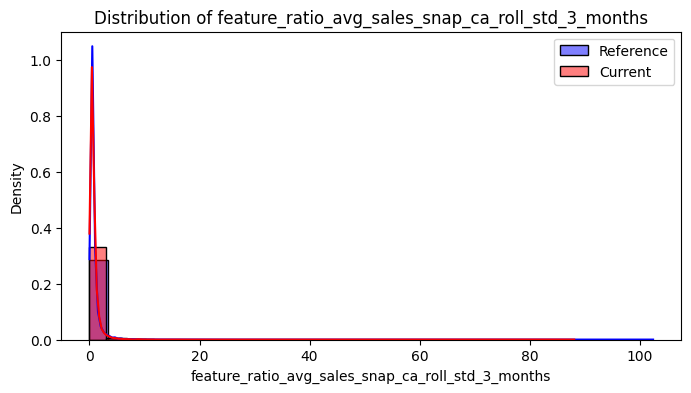

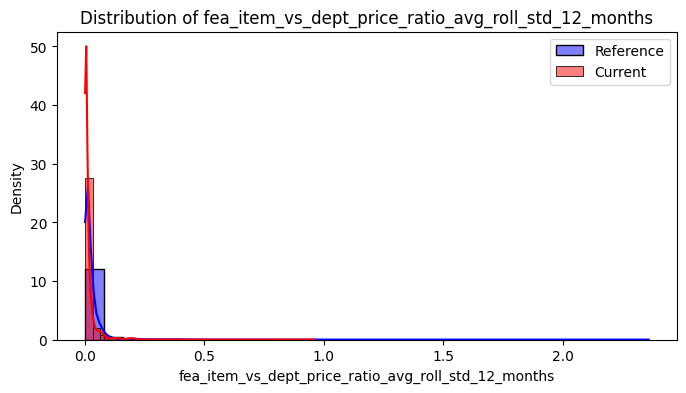

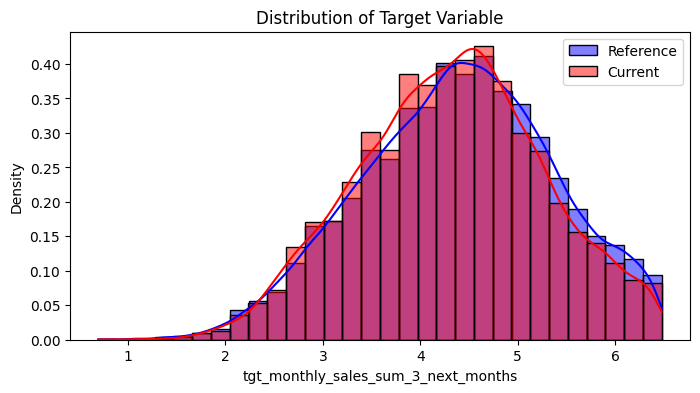

In [19]:
# Specify feature and target columns

feature_importance = pd.read_csv(f"{model.run_directory}/feature_importance.csv")
FEATURE_COLS = list(feature_importance["feature"][1:20].values)
TARGET_COL = config_loader.target_col

def plot_feature_distributions(ref_df, cur_df, features: List[str], bins=30):
    for feature in features:
        plt.figure(figsize=(8, 4))
        sns.histplot(ref_df[feature], color='blue', label='Reference', stat='density', bins=bins, kde=True, alpha=0.5)
        sns.histplot(cur_df[feature], color='red', label='Current', stat='density', bins=bins, kde=True, alpha=0.5)
        plt.title(f"Distribution of {feature}")
        plt.legend()
        plt.show()

# Plot feature distributions
plot_feature_distributions(reference_df, current_df, FEATURE_COLS)

# Plot target distribution
plt.figure(figsize=(8, 4))
sns.histplot(reference_df[TARGET_COL], color='blue', label='Reference', stat='density', bins=30, kde=True, alpha=0.5)
sns.histplot(current_df[TARGET_COL], color='red', label='Current', stat='density', bins=30, kde=True, alpha=0.5)
plt.title('Distribution of Target Variable')
plt.legend()

plt.show()

## 5. Population Stability Index (PSI)
The Population Stability Index (PSI) is a holistic metric to quantify the shift in distributions between two populations. Values above 0.2 typically indicate significant drift.

In [20]:
def calculate_psi(expected: np.ndarray, actual: np.ndarray, buckets: int = 10) -> float:
    '''
    Calculate the Population Stability Index (PSI) between two distributions.
    '''
    def scale_range(input_arr, min_val, max_val):
        input_arr = np.clip(input_arr, min_val, max_val)
        return input_arr
    
    breakpoints = np.linspace(np.min(expected), np.max(expected), buckets + 1)
    expected_percents = np.histogram(scale_range(expected, breakpoints[0], breakpoints[-1]), bins=breakpoints)[0] / len(expected)
    actual_percents = np.histogram(scale_range(actual, breakpoints[0], breakpoints[-1]), bins=breakpoints)[0] / len(actual)
    psi_value = np.sum((expected_percents - actual_percents) * np.log((expected_percents + 1e-8) / (actual_percents + 1e-8)))
    return psi_value

# Calculate PSI for all features and target
psi_results = {}
for col in FEATURE_COLS + [TARGET_COL]:
    psi = calculate_psi(reference_df[col].values, current_df[col].values)
    psi_results[col] = psi
# Display PSI results
psi_df = pd.DataFrame(list(psi_results.items()), columns=['Feature', 'PSI'])
psi_df['Drift_Flag'] = psi_df['PSI'].apply(lambda x: 'Significant' if x > 0.2 else 'Minor')
psi_df

,Feature,PSI,Drift_Flag
0,feature_avg_sales_not_snap_ca,0.004142,Minor
1,fea_item_monthly_sales_roll_std_12_months,0.000000,Minor
2,fea_item_monthly_sales_ratio_lag_2_months,0.000000,Minor
3,fea_item_monthly_sales_roll_coeffvar_12_months,0.000000,Minor
4,fea_item_monthly_sales_lag_1_months,0.005176,Minor
5,feature_avg_sales_not_sport_event,0.004269,Minor
6,fea_item_monthly_sales_ratio_lag_1_months,0.000000,Minor
7,fea_item_monthly_sales_ratio_lag_11_months,0.000000,Minor
8,fea_item_longevity_months,1.987157,Significant
9,fea_item_max_days_since_last_sale,0.000793,Minor


## 6. Drift Visualization
Visualize the PSI values and highlight features/target with significant drift.

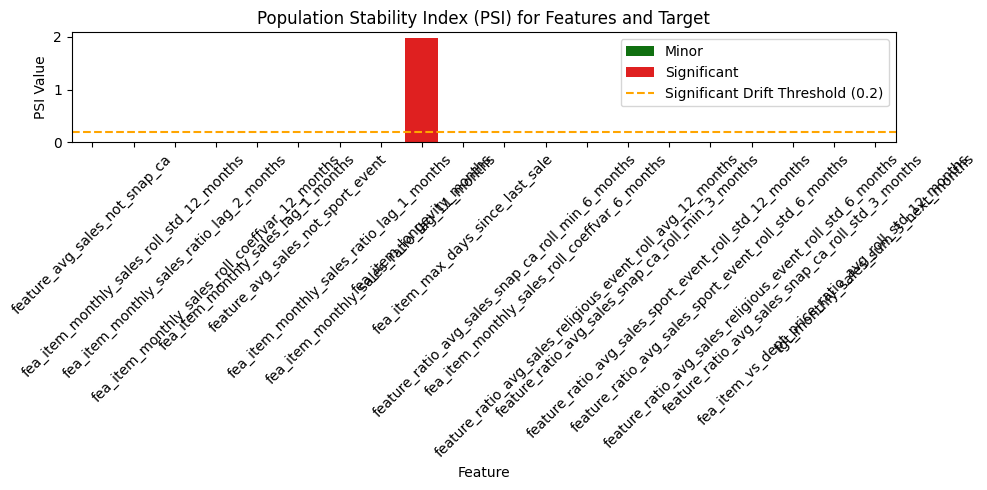

In [21]:
# Visualize PSI values
plt.figure(figsize=(10, 5))
sns.barplot(data=psi_df, x='Feature', y='PSI', hue='Drift_Flag', dodge=False, palette={'Significant':'red', 'Minor':'green'})
plt.axhline(0.2, color='orange', linestyle='--', label='Significant Drift Threshold (0.2)')
plt.title('Population Stability Index (PSI) for Features and Target')
plt.ylabel('PSI Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()